# CNN 활용 자동차 검출

### import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob, cv2

### vehicle, non-vehicle 이미지 불러와 데이터셋 추출

In [2]:
carpics = glob.glob('data/vehicles/*.png')
notcarpics = glob.glob('data/non-vehicles/*.png')

cars = []
notcars = []

for filename in carpics:
    image = cv2.imread(filename)
    cars.append(image)
    
for filename in notcarpics:
    image = cv2.imread(filename)
    notcars.append(image)

# positive, negative 데이터셋을 위한 변수 세팅
X_pos = np.array(cars, dtype=np.uint8)    
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)

X_neg = np.array(notcars, dtype=np.uint8)
y_neg = np.zeros(X_neg.shape[0], dtype=np.int32)

### positive, negative 이미지 suffle

[1, 0, 0, 0, 0]


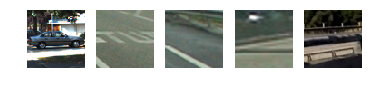

In [3]:
X_datas = np.concatenate((X_pos, X_neg))
y_datas = np.concatenate((y_pos, y_neg))

from sklearn.utils import shuffle

# 합쳐진 positive 데이터셋과 negative 데이터셋을 Suffle 하여 저장.
X_datas, y_datas = shuffle(X_datas, y_datas)

import random

samples = []

for i in range(5):
    img = X_datas[i]
    samples.append(y_datas[i])    
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
print(samples)      

### Train 데이터 셋과 Test 데이터셋 분류

In [4]:
X_trains = X_datas[:1770]
y_trains = y_datas[:1770]

X_tests = X_datas[1700:]
y_tests = y_datas[1700:]

### Keras 사용하여 학습

In [5]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

num_classes = 2

img_rows, img_cols = 64, 64

input_shape = (img_rows, img_cols, 3)

# 학습결과 softmax로 처리하위해 Y를 Onehot encoding 처리.
Y_trains = keras.utils.to_categorical(y_trains, num_classes)
Y_tests = keras.utils.to_categorical(y_tests, num_classes)

# Convolution층과 Pooling을 구성
model = Sequential()
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected 구성
model.add(Flatten())
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros'))
model.add(Dropout(0.25))
model.add(Dense(2,  activation='softmax'))

# 딥러닝 초기화 및 Activation 적용. Batch size 10, epoch 10 설정
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

history = model.fit(X_trains, Y_trains, batch_size=10, epochs=10, verbose=1, validation_split=0.2)

Using TensorFlow backend.


Train on 1416 samples, validate on 354 samples
Epoch 1/10
1416/1416 [==============================] - 3s 2ms/step - loss: 0.6795 - acc: 0.5706 - val_loss: 0.6840 - val_acc: 0.5706
Epoch 2/10
1416/1416 [==============================] - 1s 882us/step - loss: 0.5812 - acc: 0.7507 - val_loss: 0.4495 - val_acc: 0.8277
Epoch 3/10
1416/1416 [==============================] - 1s 894us/step - loss: 0.4478 - acc: 0.8517 - val_loss: 0.5527 - val_acc: 0.7175
Epoch 4/10
1416/1416 [==============================] - 1s 890us/step - loss: 0.3540 - acc: 0.8941 - val_loss: 0.3030 - val_acc: 0.9237
Epoch 5/10
1416/1416 [==============================] - 1s 894us/step - loss: 0.2879 - acc: 0.9237 - val_loss: 0.2663 - val_acc: 0.9322
Epoch 6/10
1416/1416 [==============================] - 1s 888us/step - loss: 0.2315 - acc: 0.9449 - val_loss: 0.2664 - val_acc: 0.9379
Epoch 7/10
1416/1416 [==============================] - 1s 890us/step - loss: 0.2010 - acc: 0.9569 - val_loss: 0.1818 - val_acc: 0.9633
Epo

### accuracy, loss 확인

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


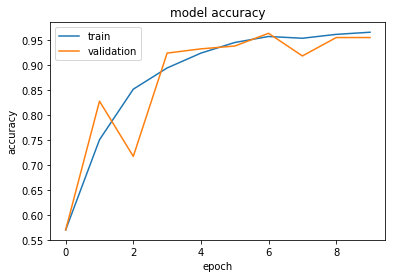

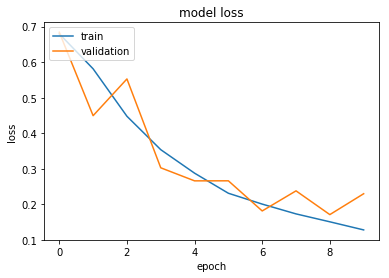

In [6]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 학습 결과 인식률 확인, model save

In [7]:
score = model.evaluate(X_trains, Y_trains, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save('cnn-vehicle-3.h5')

Test loss: 0.13463223308829939
Test accuracy: 0.9728813557975037


### test 이미지 인식 확인

In [8]:
y_prob = model.predict(X_tests) 
y_classes = y_prob.argmax(axis=-1)

print(y_classes)
print(y_tests)

[1 0 0 ... 1 1 0]
[1 0 0 ... 1 1 0]
